![logo](1_bDwEvCRgrKVbLrAXEixpfA.png)
___

##### import libraries

In [103]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

#bag of words model
from sklearn.feature_extraction.text import CountVectorizer

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#cross-validation
from sklearn.model_selection import cross_val_score

#visualizations
#!pip install wordcloud
from wordcloud import WordCloud
from pylab import *

#classification 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

# Step 6(d) - Classification (Art)

    a) Importing data

    b) N-Grams
        i) Unigram
       ii) Corpus Visualizations
      
    c) Train/Test Split
    
    d) Resampling
        i) Random Over Sampling
       ii) Random Under Sampling  

    e) Classification
        i) Original Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
       ii) Over-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
      iii) Under-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM

## a) Importing data

In [104]:
#import art_data.csv file
art_df = pd.read_csv("art_data.csv")

art_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(art_df.shape)
art_df.head(1)

(12317, 23)


,id,name,genre,subgenre,category,source_url,blurb,slug,goal,converted_pledged_amount,...,country,currency,backers_count,disable_communication,is_starrable,spotlight,staff_pick,state,success_percentage,blurb_corpus
0,1175859175,5th Anniversary Year / Five Small Fires,Conceptual Art,art,"{""id"":20,""name"":""Conceptual Art"",""slug"":""art/c...",https://www.kickstarter.com/discover/categorie...,5th Anniversary Year | FSF is about revolution...,5th-anniversary-year-five-small-fires,5000,5271,...,US,USD,53,0,0,1,0,successful,105.42,th anniversary year fsf revolutionary abstract...


In [105]:
#locate NaN
is_NaN = art_df.isna()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = art_df[row_has_NaN]

#remove NaN
art_df = art_df.dropna()
print(art_df.isna().sum())
print(art_df.shape)

id                          0
name                        0
genre                       0
subgenre                    0
category                    0
source_url                  0
blurb                       0
slug                        0
goal                        0
converted_pledged_amount    0
created_at                  0
launched_at                 0
deadline                    0
country                     0
currency                    0
backers_count               0
disable_communication       0
is_starrable                0
spotlight                   0
staff_pick                  0
state                       0
success_percentage          0
blurb_corpus                0
dtype: int64
(12317, 23)


In [106]:
art_df.reset_index(drop=True,inplace=True)

## b) N-Grams

##### i) Unigrams 

In [107]:
#entire corpus series into seperate strings
corpus_series = art_df['blurb_corpus'].apply(lambda x: str(x))
print(type(corpus_series[0]))

print(len(corpus_series))
corpus_series

<class 'str'>
12317


0        th anniversary year fsf revolutionary abstract...
1        let paint tv going search creativity space mis...
2        one unique space scene painted ink metallic se...
3        mosaic mural westside avenue adult center vent...
4        project make animal mask artistic skill develo...
                               ...                        
12312    help artist circus camp instructor teaching ki...
12313    heliopolis small storefront located greenpoint...
12314    vox paper bull need piano pianist provide musi...
12315    collaborative performance video project brothe...
12316    artist designed urban tote punkin apparel andr...
Name: blurb_corpus, Length: 12317, dtype: object

In [108]:
#getting unigrams  
vectorizer = CountVectorizer() 
X1 = vectorizer.fit_transform(corpus_series)  
features = (vectorizer.get_feature_names()) 

#applying TFIDF for unigrams
vectorizer = TfidfVectorizer() 
X2 = vectorizer.fit_transform(corpus_series) 
scores = (X2.toarray()) 

In [109]:
#getting top-ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
uni_ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
uni_words = (uni_ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", uni_words.head(20)) 



Words : 
             term        rank
751          art  383.658435
11036        pin  215.928593
793       artist  199.394533
6709        help  198.249977
4723      enamel  178.272936
10586   painting  156.050712
11537    project  146.502783
9977         new  136.156857
1697        book  125.513957
3371      create  118.606011
16279      world  110.195016
8848        make  107.554447
13333       show  107.204395
11468      print  106.998109
16267       work  105.548907
2955   community  105.498343
12989  sculpture  103.938180
8462        life  102.794265
9927        need  100.456747
13140     series   99.928773


##### ii) Corpus Visualizations

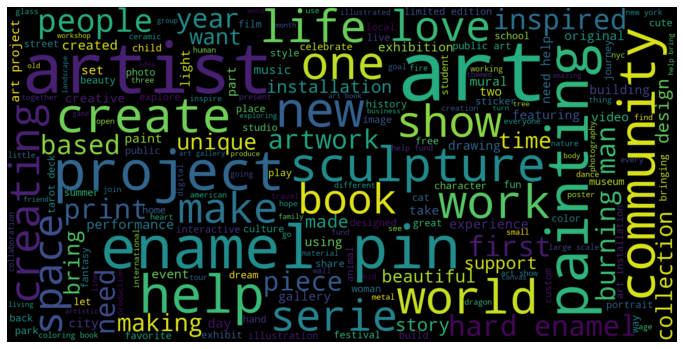

In [110]:
corpus_all = ' '.join(art_df['blurb_corpus'])

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(corpus_all)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 300 words')

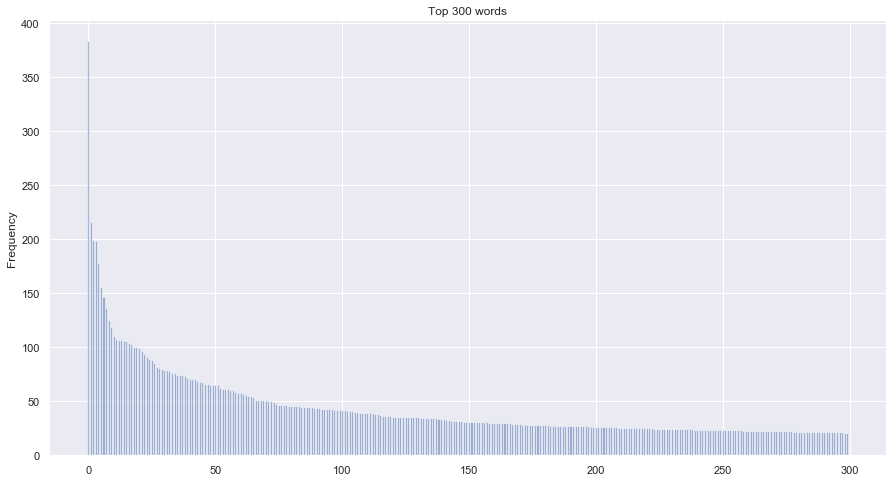

In [111]:
y_pos = np.arange(300)
plt.figure(figsize=(15,8))
plt.bar(y_pos, uni_ranking.sort_values(by='rank', ascending=False)['rank'][:300], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 300 words')

## c) Train/Test Split

In [112]:
msk = np.random.rand(len(art_df)) < 0.75

train_df = art_df[msk]
test_df = art_df[~msk]

In [113]:
print(len(test_df))
print(len(train_df))

3043
9274


In [114]:
#split test into X_test and y_test for later
y_test = test_df['state']
X_test = test_df.drop('state',axis=1)

## d) Resampling

In [115]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(train_df['state'].unique())
train_df.state.replace(['successful', 'failed'], [1, 0], inplace=True)
print(train_df['state'].unique())

['successful' 'failed']
[1 0]


C:\Users\vlad_\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [116]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(test_df['state'].unique())
test_df.state.replace(['successful', 'failed'], [1, 0], inplace=True)
print(test_df['state'].unique())

['successful' 'failed']
[1 0]


In [117]:
train_df['state'].value_counts()

1    6487
0    2787
Name: state, dtype: int64

In [118]:
#class count
count_class_1, count_class_0 = train_df.state.value_counts()

#divide by class
df_class_0 = train_df[train_df['state'] == 0]
df_class_1 = train_df[train_df['state'] == 1]

##### i) Random Over-Sampling

Random over-sampling:
1    6487
0    6487
Name: state, dtype: int64


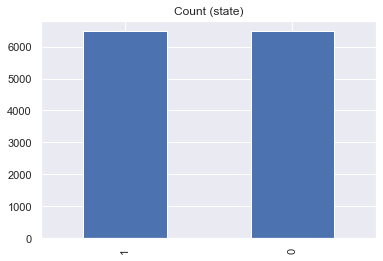

In [119]:
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.state.value_counts())

df_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

##### ii) Random under-sampling

Random under-sampling:
1    2787
0    2787
Name: state, dtype: int64


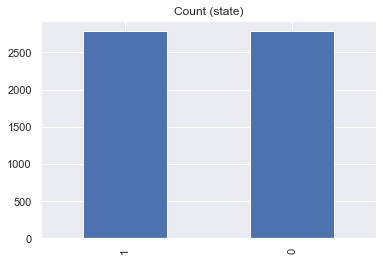

In [120]:
df_class_1_under = df_class_1.sample(count_class_0)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
df_test_under['state'].value_counts()
print('Random under-sampling:')
print(df_test_under.state.value_counts())

df_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

## e) Classification (Original data, Oversampled data, Undersampled data)

The following lines will include classification algorithms using 3 types of data: the original data with outliers removed, oversampled data, and undersampled data.

### i) Original data

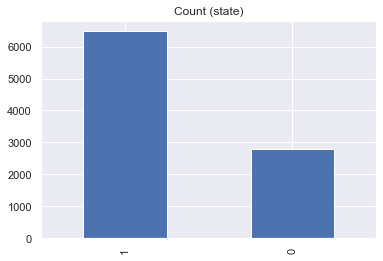

In [121]:
train_df.state.value_counts().plot(kind='bar', title='Count (state)')

In [122]:
#split into X_train and y_train
y_train = train_df['state']
X_train = train_df.drop('state',axis=1)

In [123]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_train['blurb_corpus'])
X_vec_train.shape

(9274, 72791)

In [124]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_tfidf.shape

(9274, 72791)

In [125]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(3043, 72791)

In [126]:
#apply TDIDF on test set
test_tfidf = tfidf_transformer.transform(X_vec_test)
test_tfidf.shape

(3043, 72791)

##### Naive Bayes Classifier

In [25]:
#fitting Naive Bayes Classifier to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = nb_classifier.predict(test_tfidf)

Confusion matrix:
 [[   9  973]
 [   0 2185]]


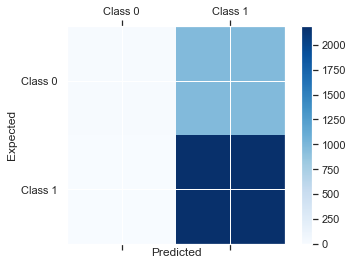

In [26]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [27]:
accText = 'Naive Bayes, Art Original'

In [28]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 69.28%
 Precision: 69.19%
    Recall: 100.00%
  F1 score: 81.79%
 ROC score: 50.46%


In [29]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier

In [30]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = reg_classifier.predict(test_tfidf)

Confusion matrix:
 [[  19  963]
 [  11 2174]]


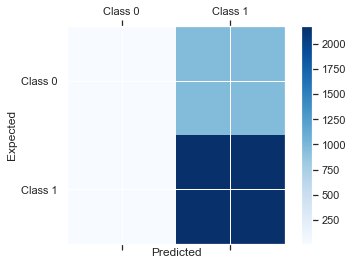

In [31]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [32]:
accText = 'Logistic Regression, Art Original'

In [33]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 69.25%
 Precision: 69.30%
    Recall: 99.50%
  F1 score: 81.70%
 ROC score: 50.72%


In [34]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [35]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_tfidf, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 25


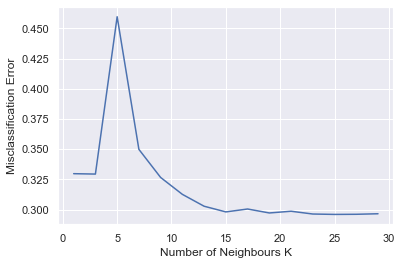

In [36]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [37]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 25, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = knn_classifier.predict(test_tfidf)

Confusion matrix:
 [[  42  940]
 [  24 2161]]


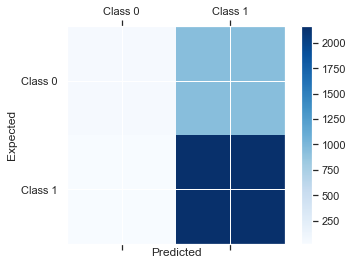

In [38]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [39]:
accText = 'KNN, Art Original'

In [40]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 69.56%
 Precision: 69.69%
    Recall: 98.90%
  F1 score: 81.76%
 ROC score: 51.59%


In [41]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [42]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = svm_classifier.predict(test_tfidf)

Confusion matrix:
 [[ 303  679]
 [ 392 1793]]


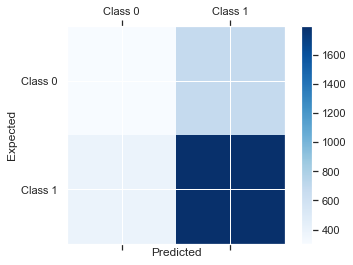

In [43]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [44]:
accText = 'SVM, Art Original'

In [45]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 66.18%
 Precision: 72.53%
    Recall: 82.06%
  F1 score: 77.00%
 ROC score: 56.46%


In [46]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

### ii) Over-sampled data

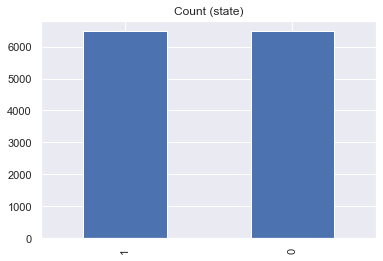

In [127]:
df2_test_over = pd.DataFrame(df_test_over)
df2_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

In [128]:
#split into X_train and y_train
X_over_train = df2_test_over.drop('state',axis=1)
y_over_train = df2_test_over['state']

In [129]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_over_train['blurb_corpus'])
X_vec_train.shape

(12974, 70674)

In [130]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_over_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_over_tfidf.shape

(12974, 70674)

In [131]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(3043, 70674)

In [132]:
#apply TDIDF on test set
test_over_tfidf = tfidf_transformer.transform(X_vec_test)
test_over_tfidf.shape

(3043, 70674)

##### Naive Bayes Classifier

In [133]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = nb_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 500  416]
 [ 692 1435]]


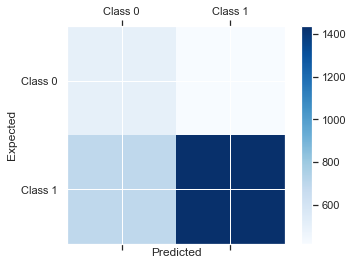

In [134]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [135]:
accText = 'Naive Bayes, Art Oversampling'

In [136]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 63.59%
 Precision: 77.53%
    Recall: 67.47%
  F1 score: 72.15%
 ROC score: 61.03%


In [137]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier

In [138]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = reg_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 231  685]
 [ 280 1847]]


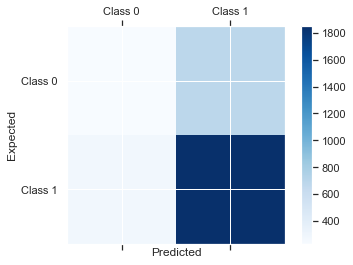

In [139]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [140]:
accText = 'Logistic Regression, Art Oversampling'

In [141]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 68.29%
 Precision: 72.95%
    Recall: 86.84%
  F1 score: 79.29%
 ROC score: 56.03%


In [142]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [63]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_over_tfidf, y_over_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 7


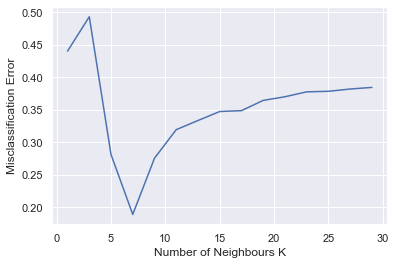

In [64]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [65]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = knn_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 417  565]
 [ 601 1584]]


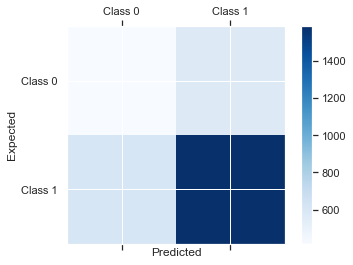

In [66]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [67]:
accText = 'KNN, Art Oversampling'

In [68]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 63.18%
 Precision: 73.71%
    Recall: 72.49%
  F1 score: 73.10%
 ROC score: 57.48%


In [69]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [143]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='log', penalty='l2')
svm_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = svm_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 231  685]
 [ 284 1843]]


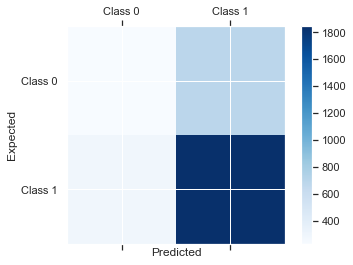

In [144]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [145]:
accText = 'SVM, Art Oversampling'

In [146]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 68.16%
 Precision: 72.90%
    Recall: 86.65%
  F1 score: 79.18%
 ROC score: 55.93%


In [147]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

### iii) Under-sampled data

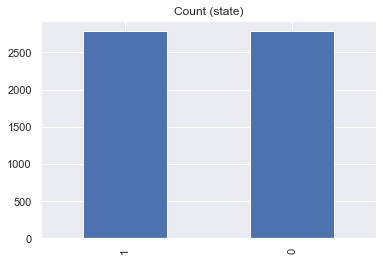

In [148]:
df2_test_under = pd.DataFrame(df_test_under)
df2_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

In [149]:
#split into X_train and y_train
X_under_train = df2_test_under.drop('state',axis=1)
y_under_train = df2_test_under['state']

In [150]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_under_train['blurb_corpus'])
X_vec_train.shape

(5574, 47412)

In [151]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_under_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_under_tfidf.shape

(5574, 47412)

In [152]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(3043, 47412)

In [153]:
#apply TDIDF on test set
test_under_tfidf = tfidf_transformer.transform(X_vec_test)
test_under_tfidf.shape

(3043, 47412)

##### Naive Bayes Classifier

In [154]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = nb_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 573  343]
 [ 884 1243]]


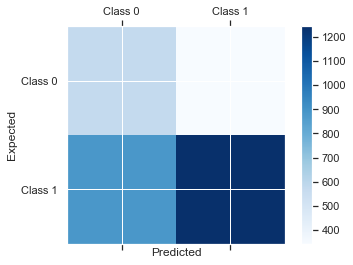

In [155]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [156]:
accText = 'Naive Bayes, Art Undersampling'

In [157]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 59.68%
 Precision: 78.37%
    Recall: 58.44%
  F1 score: 66.95%
 ROC score: 60.50%


In [158]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier


In [159]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = reg_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 633  283]
 [1024 1103]]


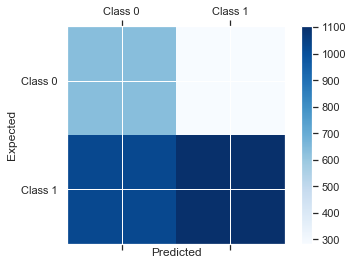

In [160]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [161]:
accText = 'Logistic Regression, Art Undersampling'

In [162]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 57.05%
 Precision: 79.58%
    Recall: 51.86%
  F1 score: 62.80%
 ROC score: 60.48%


In [163]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [91]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_under_tfidf, y_under_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 15


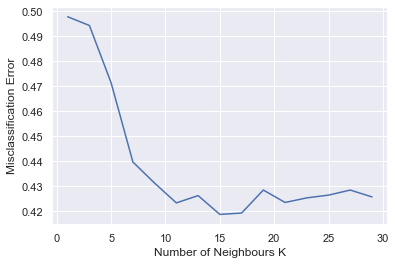

In [92]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [93]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 15, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
prediction = knn_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 808  174]
 [1393  792]]


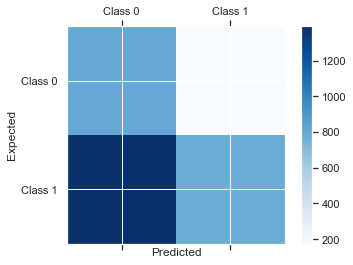

In [94]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=prediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [95]:
accText = 'KNN, Art Undersampling'

In [96]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 57.40%
 Precision: 78.44%
    Recall: 52.77%
  F1 score: 63.09%
 ROC score: 60.24%


In [97]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [164]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='log', penalty='l2')
svm_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = svm_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 610  306]
 [ 972 1155]]


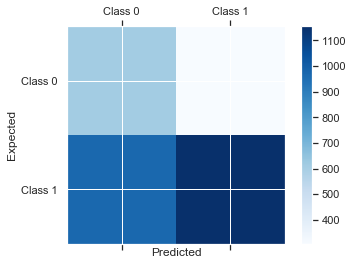

In [165]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [166]:
accText = 'SVM, Art Undersampling'

In [167]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 58.00%
 Precision: 79.06%
    Recall: 54.30%
  F1 score: 64.38%
 ROC score: 60.45%


In [168]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

## End of Step 6(d)